### Import dataset and put into dataloader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import os
import glob

# define parameters
torch.manual_seed(43)
'''
batchSize = 16
subset_size = 10000
val_size = 500
test_size = 1000
'''
batchSize = 16
subset_size = 5500
val_size = 500
test_size = 1000
model_name = "MLP_v1"

# transform
transform_ = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ])

# split and load datasets
dataset = torchvision.datasets.CIFAR10(root='../input/cifar10-python', train=True, download=False, transform=transform_)
_size = len(dataset) - subset_size
subset, _ = random_split(dataset, [subset_size, _size])

train_size = len(subset) - val_size
trainSet, validSet = random_split(subset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='../input/cifar10-python', train=False, download=False, transform=transform_)
_size = len(test_dataset) - test_size
testSet, _ = random_split(test_dataset, [test_size, _size])
testloader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=True, num_workers=2)

print("trainSet size: ", len(trainSet))
print("validSet size: ", len(validSet))
print("testset size: ", len(testSet))

fixed_trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=False, num_workers=2)
fixed_validloader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=False, num_workers=2)
fixed_testloader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=False, num_workers=2)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

trainSet size:  5000
validSet size:  500
testset size:  1000
cuda:0


### Pre-processing: Convert all rgb images to gray images

images_color shape:  torch.Size([16, 3, 32, 32])


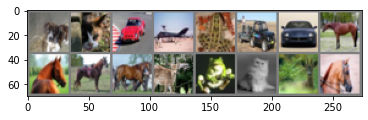

images_gray shape:  torch.Size([16, 1, 32, 32])


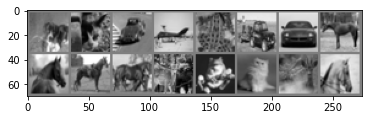

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# create folders
if not os.path.exists('./plot'):
    os.mkdir('./plot/')
if not os.path.exists('./plot/'+model_name+'/'):
    os.mkdir('./plot/'+model_name+'/')
if not os.path.exists('./plot/'+model_name+'/running_inference_train/'):
    os.mkdir('./plot/'+model_name+'/running_inference_train/')
if not os.path.exists('./plot/'+model_name+'/running_inference_valid/'):
    os.mkdir('./plot/'+model_name+'/running_inference_valid/')
if not os.path.exists('./plot/'+model_name+'/inference/'):
    os.mkdir('./plot/'+model_name+'/inference/')

    
if not os.path.exists('./saved_model'):
    os.mkdir('./saved_model/')

# functions to show an image
def imshow(img, name=""):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.savefig('plot/'+model_name+'/'+name+'.png')
    plt.show()

# get some random training images
images_color, labels = next(iter(trainloader))

# function to convert a rgb_img to gray_img
def rgb2gray(img):
    rgb_img = img.transpose(1,2,0)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    return gray_img

# function to convert a batch of rgb images to gray images
def rgb2gray_batch(images):
    rgb_images = np.array(images)    
    
    gray_images = []
    for i in range(rgb_images.shape[0]):
        img = rgb_images[i]
        gray_img = rgb2gray(img)
        gray_images.append(gray_img)
    
    gray_images = np.array(gray_images)
    gray_images = torch.from_numpy(gray_images)
    return gray_images
        
images_gray = rgb2gray_batch(images_color)

# show images
print("images_color shape: ", images_color.shape)
imshow(torchvision.utils.make_grid(images_color), name="color_sample")
images_gray = images_gray.reshape(batchSize,1,32,32)
print("images_gray shape: ", images_gray.shape)
imshow(torchvision.utils.make_grid(images_gray), name="gray_sample")

### Define the MLP network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_net(nn.Module):
    def __init__(self):
        # Input layer is 1024, since CIFAR-10 gray_image is 1x32x32
        # Output layer is 3072, since CIFAR-10 gray_image is 3x32x32
        super(MLP_net, self).__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Sigmoid(),
            
            nn.Linear(1024, 3072),
            nn.BatchNorm1d(3072),
            #nn.Sigmoid()

        )
        
    def forward(self, x):
        # convert tensor (4, 1, 32, 32) --> (4, 1*32*32)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        
        return x

model = MLP_net().to(device)

print("GPU: ", next(model.parameters()).is_cuda)

model_path = "./saved_model/"+model_name + ".pt"
if os.path.exists(model_path):
    print("Continue training from the saved model")
    model.load_state_dict(torch.load(model_path))

GPU:  True


### Define the loss function and optimizer

In [4]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# criterion
criterion = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005) #betas=(0.9, 0.999), eps=1e-08, weight_decay=0
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# load previous trained model 
if os.path.exists(model_path):
    print("Continue training from the saved model")
    model.load_state_dict(torch.load(model_path))
    
# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./runs/"+model_name+"/")
# plot_writer = SummaryWriter("./runs_plot/"+model_name+"/")

# Write current finished epoch num to a txt file
if not os.path.exists("./runs/"+model_name+"/epoch.txt"):
    fileEpoch = open("./runs/"+model_name+"/epoch.txt","w") 
    fileEpoch.write("-1")
    fileEpoch.close()

# Read previous finished epoch num from a txt file
fileEpoch = open("./runs/"+model_name+"/epoch.txt","r")
prev_epoch = int(fileEpoch.read())+1
print("previous finished epoch nums: ", prev_epoch)
fileEpoch.close()

previous finished epoch nums:  0


In [5]:
def make_grid(loaderName, k, prefix):
    print(("inference on " + prefix + ":"))
    
    images_color, _ = next(iter(loaderName))
#     print("images_color: ", images_color.shape)
    images_color_show = images_color.reshape(batchSize,3,32,32)
#     imshow(torchvision.utils.make_grid(images_color_show.detach()), name="inference_Train_color")

    images_gray = rgb2gray_batch(images_color)
#     print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(batchSize,1,32,32)
#     imshow(torchvision.utils.make_grid(images_gray.detach()), name="inference_Train_gray")

    # run inference on the network
    images_gray = images_gray.to(device)
    outputs = model(images_gray)
    outputs = outputs.reshape(batchSize,3,32,32)
    outputs = outputs.to("cpu")
    
    # show the gray & output images in grid
    images_gray = images_gray.to("cpu")
    images_gray = torch.cat((images_gray, images_gray, images_gray), 1)
    merged_out = torch.cat((images_gray, outputs),0)
    imshow(torchvision.utils.make_grid(merged_out.detach()), name="running_inference_"+ prefix + "/trainData_"+str(format(k, '04d')))
    
#     grid_output = torchvision.utils.make_grid(outputs.detach())
#     plot_writer.add_image(str(loaderName), grid_output, k)

### Train the network

In [6]:
'''
history_train_loss = []
history_valid_loss = []
train_epoch_loss = 0
valid_epoch_loss = 0
print("Start training from Epoch: ", prev_epoch+1)
for epoch in range(prev_epoch, prev_epoch+100):  # loop over the dataset multiple times
    train_running_loss = 0.0
    valid_running_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    print("Training Mode...")
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, _ = data
        images_gray = rgb2gray_batch(images_color)
        
        # flatten and put data into gpu/cpu
        images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
        images_color_flat = images_color.reshape(images_color.shape[0], -1)
        images_gray_flat = images_gray_flat.to(device)
        images_color_flat = images_color_flat.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # Size - images_gray: [batchSize, 1024]
        outputs = model(images_gray_flat)
    
        # Backward
        # Size - images_color_flat: [batchSize,3072]
        # Size - outputs: [batchSize,3072]
        train_loss = criterion(outputs, images_color_flat)
        train_loss.backward()
        optimizer.step()

        # print output statistics
        train_epoch_loss += train_loss.item()
        train_running_loss += train_loss.item()
        
        j = 50              # print every j mini-batches
        if i % j == (j-1):     # print every j mini-batches
            print('[%d, %5d] train loss: %.3f' %
                  (epoch + 1, i + 1, train_running_loss / j))
            
            writer.add_scalar('Loss/train', train_running_loss/j, len(trainloader)*epoch + i)
            train_running_loss = 0.0
        
    ###################
    # validate the model #
    ###################
    model.eval()
    print("Validation Mode...")
    with torch.no_grad():
        for k, data in enumerate(validloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images_color, _ = data
            images_gray = rgb2gray_batch(images_color)

            # flatten and put data into gpu/cpu
            images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
            images_color_flat = images_color.reshape(images_color.shape[0], -1)
            images_gray_flat = images_gray_flat.to(device)
            images_color_flat = images_color_flat.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Size - images_gray: [batchSize, 1024]
            outputs = model(images_gray_flat)

            # Backward
            # Size - images_color_flat: [batchSize,3072]
            # Size - outputs: [batchSize,3072]
            valid_loss = criterion(outputs, images_color_flat)

            # print output statistics
            valid_epoch_loss += valid_loss.item()
            valid_running_loss += valid_loss.item()
    
        print('[%d, _] validation loss: %.3f' %
              (epoch + 1, valid_running_loss/(k+1)))

        writer.add_scalar('Loss/valid', valid_running_loss/(k+1), len(trainloader)*(epoch+1))
        valid_running_loss = 0.0
        
    # Save the summary and loss, after each epoch
    make_grid(fixed_trainloader, epoch, "train")
    make_grid(fixed_validloader, epoch, "valid")
    history_train_loss.append(train_epoch_loss/(i+1))
    history_valid_loss.append(valid_epoch_loss/(k+1))
    train_epoch_loss = 0.0
    valid_epoch_loss = 0.0

    
# write finished epoch nums to txt file
fileEpoch = open("./runs/"+model_name+"/epoch.txt","w") 
fileEpoch.write(str(epoch))
fileEpoch.close()

# clean summary writer
writer.flush()
writer.close()
# plot_writer.flush()
# plot_writer.close()
print('Finished Training')
'''

'\nhistory_train_loss = []\nhistory_valid_loss = []\ntrain_epoch_loss = 0\nvalid_epoch_loss = 0\nprint("Start training from Epoch: ", prev_epoch+1)\nfor epoch in range(prev_epoch, prev_epoch+100):  # loop over the dataset multiple times\n    train_running_loss = 0.0\n    valid_running_loss = 0.0\n    \n    ###################\n    # train the model #\n    ###################\n    model.train()\n    print("Training Mode...")\n    for i, data in enumerate(trainloader, 0):\n        # get the inputs; data is a list of [inputs, labels]\n        images_color, _ = data\n        images_gray = rgb2gray_batch(images_color)\n        \n        # flatten and put data into gpu/cpu\n        images_gray_flat = images_gray.reshape(images_color.shape[0], -1)\n        images_color_flat = images_color.reshape(images_color.shape[0], -1)\n        images_gray_flat = images_gray_flat.to(device)\n        images_color_flat = images_color_flat.to(device)\n        \n        # zero the parameter gradients\n       

In [7]:
history_train_loss = []
train_epoch_loss = 0

dataiter = iter(fixed_trainloader)


images_color, labels = dataiter.next()
print("Start training from Epoch: ", prev_epoch+500)
for epoch in range(prev_epoch, prev_epoch+500):  # loop over the dataset multiple times
    train_running_loss = 0.0
    valid_running_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    # get the inputs; data is a list of [inputs, labels]
    #images_color, _ = data
    images_gray = rgb2gray_batch(images_color)

    # flatten and put data into gpu/cpu
    images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
    images_color_flat = images_color.reshape(images_color.shape[0], -1)
    images_gray_flat = images_gray_flat.to(device)
    images_color_flat = images_color_flat.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward
    # Size - images_gray: [batchSize, 1024]
    outputs = model(images_gray_flat)

    # Backward
    # Size - images_color_flat: [batchSize,3072]
    # Size - outputs: [batchSize,3072]
    train_loss = criterion(outputs, images_color_flat)
    train_loss.backward()
    optimizer.step()

    # print output statistics
    train_epoch_loss += train_loss.item()
    train_running_loss += train_loss.item()

    j = 1              # print every j mini-batches
    if i % j == (j-1):     # print every j mini-batches
        print('[%d, %5d] train loss: %.3f' %
              (epoch + 1, i + 1, train_running_loss / j))

        writer.add_scalar('Loss/train', train_running_loss/j, len(trainloader)*epoch + i)
        train_running_loss = 0.0



    # Save the summary and loss, after each epoch
    make_grid(fixed_trainloader, epoch, "train")
    history_train_loss.append(train_epoch_loss/(i+1))
    train_epoch_loss = 0.0

    
# write finished epoch nums to txt file
fileEpoch = open("./runs/"+model_name+"/epoch.txt","w") 
fileEpoch.write(str(epoch))
fileEpoch.close()

# clean summary writer
writer.flush()
writer.close()
# plot_writer.flush()
# plot_writer.close()
print('Finished Training')

Start training from Epoch:  500


NameError: name 'i' is not defined

NameError: name 'history_valid_loss' is not defined

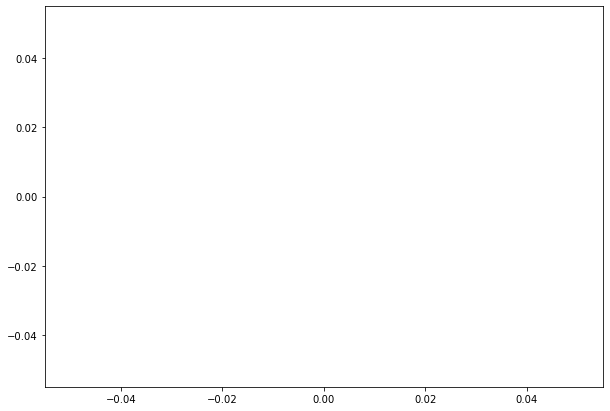

In [8]:
### Plot a graph of Training Loss and Validation Loss together

f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(range(len(history_train_loss)), history_train_loss, label = "train_loss") # Loss curve for training set
plt.plot(range(len(history_valid_loss)), history_valid_loss, label = "valid_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("runs/"+model_name+"/Loss_curve.png")
plt.show()

### Inference

In [9]:
def inference(loaderName, prefix):
    print(prefix)
    images_color, _ = next(iter(loaderName))
#     print("images_color: ", images_color.shape)
    images_color_show = images_color.reshape(batchSize,3,32,32)
#     imshow(torchvision.utils.make_grid(images_color_show.detach()), name="inference/"+prefix+"color")

    images_gray = rgb2gray_batch(images_color)
#     print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(batchSize,1,32,32)
#     imshow(torchvision.utils.make_grid(images_gray.detach()), name="inference/"+ prefix+"gray")

    # run inference on the network
    images_gray = images_gray.to(device)
    outputs = model(images_gray)
    outputs = outputs.reshape(batchSize,3,32,32)
    outputs = outputs.to("cpu")
    
    images_gray = images_gray.to("cpu")
    images_gray = torch.cat((images_gray, images_gray, images_gray), 1)
    merged_out = torch.cat((images_color_show, images_gray, outputs),0)
    
    imshow(torchvision.utils.make_grid(merged_out.detach()), name="inference/"+prefix+"_outputs")

train


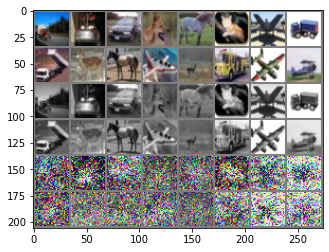

train


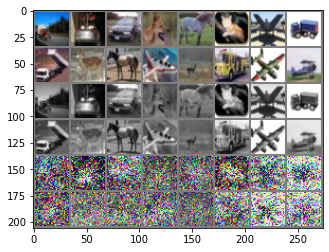

valid


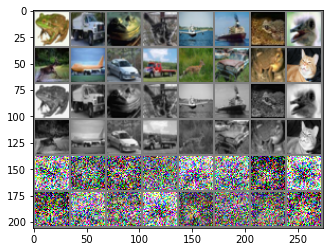

test


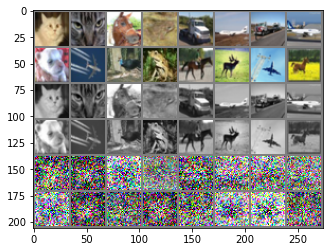

In [10]:
inference(fixed_trainloader, "train")
inference(fixed_trainloader, "train")
inference(fixed_validloader, "valid")
inference(fixed_testloader, "test")

### Test the model

In [11]:
###################
# test the model #
###################
model.eval()
test_running_loss = 0.0
print("Test Mode...")
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, _ = data
        images_gray = rgb2gray_batch(images_color)

        # flatten and put data into gpu/cpu
        images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
        images_color_flat = images_color.reshape(images_color.shape[0], -1)
        images_gray_flat = images_gray_flat.to(device)
        images_color_flat = images_color_flat.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # Size - images_gray: [batchSize, 1024]
        outputs = model(images_gray_flat)

        # Backward
        # Size - images_color_flat: [batchSize,3072]
        # Size - outputs: [batchSize,3072]
        test_loss = criterion(outputs, images_color_flat)

        # print output statistics
        test_running_loss += test_loss.item()

    print('test loss: %.5f' %
          (test_running_loss/(i+1)))

Test Mode...
test loss: 0.29380


### Save the model

In [12]:
if not os.path.exists('./saved_model'):
    os.makedirs('./saved_model')
torch.save(model.state_dict(), model_path)